In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("pitchbatcomplete.csv")
df.isna().sum()

ab_id         0
batter_id     0
g_id          0
inning        0
pitcher_id    0
pitch_type    0
away_team     0
date          0
id            0
nameID        0
playerID      0
yearID        0
PA            0
OBP           0
SLUG          0
BA            0
PCA           0
nameFirst     0
nameLast      0
debut         0
finalGame     0
dtype: int64

In [3]:
#drop yearId column because it's not really relevent
df = df.drop(columns = ['yearID'], axis = 1)

In [113]:
df.pitch_type.value_counts()

0    421487
1    230541
Name: pitch_type, dtype: int64

### Visualization

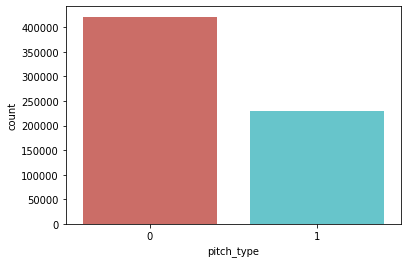

In [4]:
sns.countplot(x = 'pitch_type', data = df, palette = 'hls')

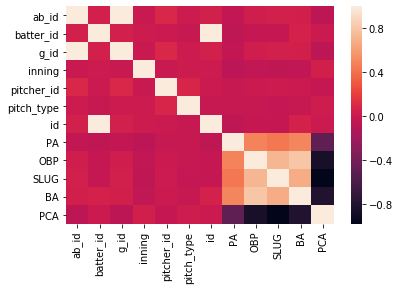

In [5]:
corr_matrix = df.corr()
ax = sns.heatmap(corr_matrix)

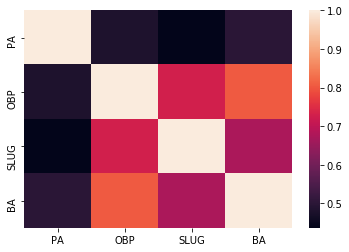

In [6]:
#high correlation in the batting stats 
df_batting = df[['PA','OBP','SLUG','BA']]
corr = df_batting.corr()
ax = sns.heatmap(corr)

In [7]:
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

In [8]:
from scipy.special import expit

In [9]:
x = df['PCA']
xp = expit(x)

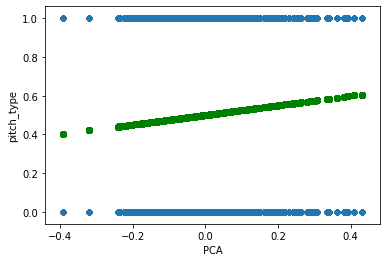

In [10]:
#view the graph
fig, ax = plt.subplots()
ax = df.plot.scatter(x='PCA', y = 'pitch_type', ax = ax)
plt.plot(x,xp,'go')

# MODELING
Using pitch_type as y and batters pca as x 

### LINEAR REGRESSION

In [11]:
from patsy import dmatrices
from sklearn import linear_model
import statsmodels.api as sm

In [12]:
yl, Xl = dmatrices('pitch_type~PCA-1', data = df)

In [13]:
lmdl = linear_model.LinearRegression
lin_mdl = lmdl(fit_intercept = True, normalize = False).fit(Xl, np.ravel(yl))

In [14]:
lsm = sm.OLS(yl,Xl).fit()
lsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             pitch_type   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.053
Method:                 Least Squares   F-statistic:                          3.627e+04
Date:                Thu, 16 Apr 2020   Prob (F-statistic):                        0.00
Time:                        11:41:23   Log-Likelihood:                     -5.6860e+05
No. Observations:              652028   AIC:                                  1.137e+06
Df Residuals:                  652027   BIC:                                  1.137e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PCA           -1.4050      0.007   -190.438      0.000      -1.419      -1.391
==============================================================================
Omnibus:                  5701239.419   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89043.990
Skew:                           0.569   Prob(JB):                         0.00
Kurtosis:                       1.592   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LOGISTIC REGRESSION THROUGH STATSMODEL

In [15]:
log_mdl = smf.logit('pitch_type~PCA', data = df).fit()
print(log_mdl.summary())

Optimization terminated successfully.
         Current function value: 0.649417
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             pitch_type   No. Observations:               652028
Model:                          Logit   Df Residuals:                   652026
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:               0.0003306
Time:                        11:41:26   Log-Likelihood:            -4.2344e+05
converged:                       True   LL-Null:                   -4.2358e+05
Covariance Type:            nonrobust   LLR p-value:                 7.146e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5841      0.003   -206.488      0.000      -0.590      -0.579
PCA            0.4888      0.

### LOGISTIC REGRESSION THROUGH SKLEARN

In [16]:
yl, Xl = dmatrices("pitch_type~PCA-1", data = df, return_type = 'dataframe')

#without penalty
mdl = LogisticRegression(penalty = 'none',solver = 'lbfgs').fit(Xl,np.ravel(yl))
#coefficient for the logistic regression model
cmdl = mdl.coef_
print("Without penalty:",cmdl)
#with default penalty
pmdl = LogisticRegression(solver = 'lbfgs').fit(Xl,np.ravel(yl))
#coefficient for the logistic regression model
l2mdl = pmdl.coef_
print("With default l2 penalty:",l2mdl)

Without penalty: [[0.48884227]]
With default l2 penalty: [[0.48842602]]


Based on the coef value they are too similar to tell the difference so we could just pic the logistic regression with or without penalty

### ROC CURVE 

In [17]:
from sklearn import metrics

In [28]:
pred_prob = mdl.predict_proba(Xl)

In [47]:
pred_prob

array([[0.65754862, 0.34245138],
       [0.65754862, 0.34245138],
       [0.65754862, 0.34245138],
       ...,
       [0.64986481, 0.35013519],
       [0.64986481, 0.35013519],
       [0.64986481, 0.35013519]])

In [25]:
mdl_roc = mbdl.score(Xl,np.ravel(yl))
print(mdl_roc)

0.6464246934180741


In [33]:
fpr, tpr, thresholds = metrics.roc_curve(np.ravel(yl),pred_prob[:,1])

In [19]:
#roc model with penalty
roc_mdl = pmdl.predict_proba(Xl)

##### ROC CURVE

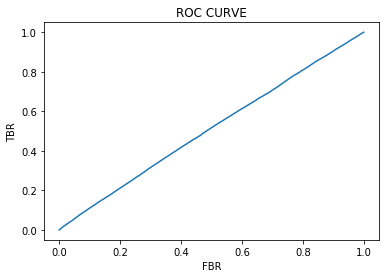

In [96]:
plt.title("ROC CURVE")
plt.xlabel("FBR")
plt.ylabel("TBR")
plt.plot(fpr,tpr)

Model is ineffective as the ROC curve hugs the 50% which means that it can't predict if the next pitch is going to be a fast ball or a non fast-ball

##### Confusion Matrix to check if the ROC CURVE IS correct

In [48]:
from sklearn.model_selection import train_test_split

In [85]:
X = df['PCA']
y = df['pitch_type']

In [86]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size =0.2,random_state=0)

In [87]:
y_train_ar = np.array(y_train)
X_train_ar = np.array(X_train)
y_train_re = np.reshape(y_train_ar,(-1,1))
X_train_re = np.reshape(X_train_ar,(-1,1))

X_test_ar = np.array(X_test)
X_test_re = np.reshape(X_test_ar,(-1,1))
y_test_ar = np.array(y_test)
y_test_re = np.reshape(y_test_ar,(-1,1))

In [90]:
logreg = LogisticRegression(solver = 'lbfgs')
logreg.fit(X_train_re,np.ravel(y_train_re))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
y_pred = logreg.predict(X_test_re)

In [95]:
matx = metrics.confusion_matrix(y_test,y_pred)
matx

array([[84337,     0],
       [46069,     0]], dtype=int64)

IF there is no false or positive negative then that means the model is not effective

### RANDOM FOREST

In [98]:
x = df['PCA']
y = df['pitch_type']

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
y_train_ar = np.array(y_train)
X_train_ar = np.array(X_train)
y_train_re = np.reshape(y_train_ar,(-1,1))
X_train_re = np.reshape(X_train_ar,(-1,1))

X_test_ar = np.array(X_test)
X_test_re = np.reshape(X_test_ar,(-1,1))
y_test_ar = np.array(y_test)
y_test_re = np.reshape(y_test_ar,(-1,1))

In [102]:
x_ar = np.array(x)
y_ar = np.array(y)

x_re = np.reshape(x_ar,(-1,1))
y_re = np.reshape(y_ar,(-1,1))

In [104]:
regressor = RandomForestRegressor(random_state = 0)
regressor.fit(x_re,np.ravel(y_re))

C:\Users\David\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

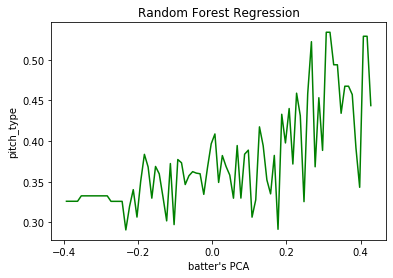

In [112]:
X_grid = np.arange(min(x), max(x), 0.01)
X_grid = X_grid.reshape((len(X_grid),1))

#plot predict data
plt.plot(X_grid, regressor.predict(X_grid), color = 'green')
plt.title("Random Forest Regression")
plt.xlabel("batter's PCA")
plt.ylabel("pitch_type")
plt.show()
           